## PART 1 : Import necessary functions, set parameters and load your own recordings ##

#### Import librairies, custom functions and set repository folder ####

In [154]:
# Importation of librairies and functions
import os
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [155]:
# check some package versions for documentation and reproducibility
import sys
import mne
from matplotlib import __version__ as plt_version
import scipy
print('Python sys', sys.version)
print('pandas', pd.__version__)
print('numpy', np.__version__)
print('mne', mne.__version__)
print('sci-py', scipy.__version__)
print('matplotlib', plt_version)

Python sys 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:14:58) [MSC v.1929 64 bit (AMD64)]
pandas 1.5.3
numpy 1.23.5
mne 1.3.0
sci-py 1.10.0
matplotlib 3.6.3


In [156]:
def set_cd_repo_folder():
    """sets current working directory to main repo folder"""
    cd = os.getcwd()

    check = 0

    while os.path.basename(cd) != 'ReSync':

        cd = os.path.dirname(cd)
        check += 1
        if check > 10: raise ValueError('Repo path not found')
    
    os.chdir(cd)

    print(f'working directory changed to {os.getcwd()}')

    return os.getcwd()


In [157]:
project_path = set_cd_repo_folder()

working directory changed to c:\Users\Juliette\Research\Projects\Synchronization_project\Code\ReSync


In [158]:
# import custom-made functions
import functions.preprocessing as preproc
import functions.utils as utils
import functions.plotting as plot
import functions.find_artefacts as artefact
import functions.crop as crop
import functions.main_resync as resync
#import functions.plotting_interactive as plot_interact

In [187]:
importlib.reload(plot)
importlib.reload(preproc)
importlib.reload(utils)
importlib.reload(artefact)
importlib.reload(crop)
importlib.reload(resync)
#importlib.reload(plot_interact)

<module 'functions.main_resync' from 'c:\\Users\\Juliette\\Research\\Projects\\Synchronization_project\\Code\\ReSync\\functions\\main_resync.py'>

#### Load your own LFP data: ####

Resulting variables needed for subsequent analysis:
- LFP_array (np.ndarray, 6d): the LFP recording which has to be aligned, containing all channels
- lfp_sig (np.ndarray, 1d): the channel containing the LFP signal from the hemisphere where the stimulation was delivered to create artefacts
- LFP_rec_ch_names (list): names of all the channels, in a list (will be used to annotate cropped recording)
- sf_LFP (int): sampling frequency of intracerebral signal


In [160]:
# load pyPerceive functions
os.chdir(os.path.dirname(os.getcwd()))
os.chdir(os.path.join(os.getcwd(), 'PyPerceive'))
os.chdir(os.path.join(os.getcwd(), 'code'))
pyPerceive_path = os.getcwd()
print (f'working dir to go fetch PyPerceive functions:{pyPerceive_path}')

from PerceiveImport.classes import (
    main_class, modality_class, metadata_class,
    session_class, condition_class, task_class,
    contact_class, run_class
)
import PerceiveImport.methods.load_rawfile as load_rawfile
import PerceiveImport.methods.find_folders as find_folders
import PerceiveImport.methods.metadata_helpers as metaHelpers

#reset the proper working directory for the analysis
os.chdir(project_path)
print (f'working dir set back to:{project_path}')

working dir to go fetch PyPerceive functions:c:\Users\Juliette\Research\Projects\Synchronization_project\Code\PyPerceive\code
working dir set back to:c:\Users\Juliette\Research\Projects\Synchronization_project\Code\ReSync


In [179]:
# choose LFP file
sub024 = main_class.PerceiveData(
    sub = "024", 
    incl_modalities=['streaming'],
    incl_session = ["fu24m"],
    incl_condition =['m0s0','m0s1','m1s0','m1s1'],
    incl_task = ["rest","fingerTap"],
    # incl_contact = ["RingL", "SegmInterR", "SegmIntraR"],
    import_json=False,
    warn_for_metaNaNs=True,
    allow_NaNs_in_metadata=False
)

# define LFP data
LFP_rec = sub024.streaming.fu24m.m0s0.rest.run1.data
LFP_array = LFP_rec.get_data()
ch_i = 0 #choose index of the channel containing the stim artefacts (O for left hemisphere, 1 for right hemisphere)
lfp_sig = LFP_rec.get_data()[ch_i]
LFP_rec_ch_names = LFP_rec.ch_names
sf_LFP = int(LFP_rec.info["sfreq"])

n_chan = len(LFP_rec.ch_names)
time_duration_LFP = (LFP_rec.n_times/LFP_rec.info['sfreq']).astype(float)
print(     
	f'The data object has:\n\t{LFP_rec.n_times} time samples,'      
	f'\n\tand a sample frequency of {LFP_rec.info["sfreq"]} Hz'      
	f'\n\twith a recording duration of {time_duration_LFP} seconds.'      
	f'\n\t{n_chan} channels were labeled as \n{LFP_rec.ch_names}.')
print(f'The channel containing artefacts has index {ch_i} and is named {LFP_rec.ch_names[ch_i]}')


	### WARNING: NaNs in Metadata Table sub-024 ###
NaNs in: sub024_ses-2021061806255999_run-BrainSense20210618063700.mat
NaNs in: sub024_ses-2021061806255999_run-BrainSense20210618064000.mat
NaNs in: sub024_ses-2021061806255999_run-BrainSense20210618064200.mat
NaNs in: sub024_ses-2021061808253999_run-BrainSense20210618084000.mat
NaNs in: sub024_ses-2021061808253999_run-BrainSense20210618084300.mat
NaNs in: sub024_ses-2021061808253999_run-BrainSense20210618084700.mat
NaNs in: sub024_ses-2021092106385396_run-BrainSense20210921070500.mat
NaNs in: sub024_ses-2021092106385396_run-BrainSense20210921072300.mat
NaNs in: sub024_ses-2021092107452096_run-BrainSense20210921074800.mat
NaNs in: sub024_ses-2021092107452096_run-BrainSense20210921080600.mat
NaNs in: sub024_ses-2021092107452096_run-BrainSense20210921082400.mat
NaNs in: sub-20210615PStn_ses-2022061010445782_run-BrainSense20220610105800.mat
NaNs in: sub-20210615PStn_ses-2022061010445782_run-BrainSense20220610111500.mat
NaNs in: sub-2021061

#### Load your own external data: ####
(our external data recorder is a TMSi Data recorder.)

PM: NOTICE THE POP UP WINDOW AFTER RUNNING, TO SELECT THE FILE LOCATION

Resulting variables:
- external_file (np.ndarray, multi-dimensional): the complete external recording containing all channels recorded
- BIP_channel (np.ndarray, 1d): the channel containing the signal from the bipolar electrode used to pick up the artefacts on the IPG/cable
- external_rec_ch_names (list, same length as the number of channels in external_file): list of the channels names, to rename them accordingly after alignment
- sf_external (int): sampling frequency of the external data recorder

In [163]:
import functions.tmsi_poly5reader as poly5_reader
import functions.loading_TMSi as loading

In [181]:
importlib.reload(loading)

<module 'functions.loading_TMSi' from 'c:\\Users\\Juliette\\Research\\Projects\\Synchronization_project\\Code\\ReSync\\functions\\loading_TMSi.py'>

In [182]:
TMSi_data = poly5_reader.Poly5Reader()  # open TMSi data from poly5
(BIP_channel,
 external_file,
 external_rec_ch_names,
 sf_external) = loading.load_TMSi_artefact_channel(TMSi_data) # function adapted for our own data recorder, 
# to load all necessary variables

Reading file  C:/Users/Juliette/OneDrive - Charité - Universitätsmedizin Berlin/Recordings/TMSi files/sub-024/24MU/MedOFF/Sub_024_24MFU_M0S0_BrStr_restTap - 20230822T100723/Sub_024_12MFU_M0S0_BrStr_restTap-20230822T100723.DATA.Poly5
	 Number of samples:  5938608 
	 Number of channels:  11 
	 Sample rate: 4096 Hz
Done reading data.
Creating RawArray with float64 data, n_channels=11, n_times=5938608
    Range : 0 ... 5938607 =      0.000 ...  1449.855 secs
Ready.
The data object has:
	5938608 time samples,
	and a sample frequency of 4096.0 Hz
	with a recording duration of 1449.85546875 seconds.
	11 channels were labeled as 
['BIP 01', 'BIP 02', 'BIP 03', 'X-0', 'Y-0', 'Z-0', 'X-1', 'Y-1', 'Z-1', 'STATUS', 'Counter 2power24'].
the channel used to align datas is the channel named BIP 01 and has index 0


## **READ ME** ##

Before starting the run_resync function, be careful to check that the config file is properly set. In particular, pay attention to:
- write the proper subject ID (to not overwrite previous analysis)
- by default use kernel "2", and set "real_index_LFP" to 0 for the first run. This can be adjusted if necessary before re-running.
- by default, set "consider_first_seconds_LFP", "consider_first_seconds_external" and "ignore_first_seconds_external" to null. 

Default parameters to adjust for our systems are:

- For TMSi SAGA with sf = 4000Hz or 4096Hz : thresh_external = -0.001, ch_name_BIP = "BIP 01"
- For TMSi Porti with sf = 2048Hz : thresh_external = -2000, ch_name_BIP = "Bip25"

In [185]:
%matplotlib inline

## PART 2: Align recordings: ##

In [184]:
(LFP_df_offset, 
 external_df_offset) = resync.run_resync(
    LFP_array=LFP_array,
    lfp_sig=lfp_sig,
    LFP_rec_ch_names=LFP_rec_ch_names,
    sf_LFP = sf_LFP,
    external_file=external_file,
    BIP_channel=BIP_channel,
    external_rec_ch_names=external_rec_ch_names,
    sf_external = sf_external,
    SHOW_FIGURES = True
)

signal is inverted
Alignment performed ! 
Please check carefully in all figures that the samples selected 
as start of the artefact are correct, and if they are not 
please correct parameters accordingly in the config file before re-running


## PART 3 : Look for timeshift ##

signal is inverted


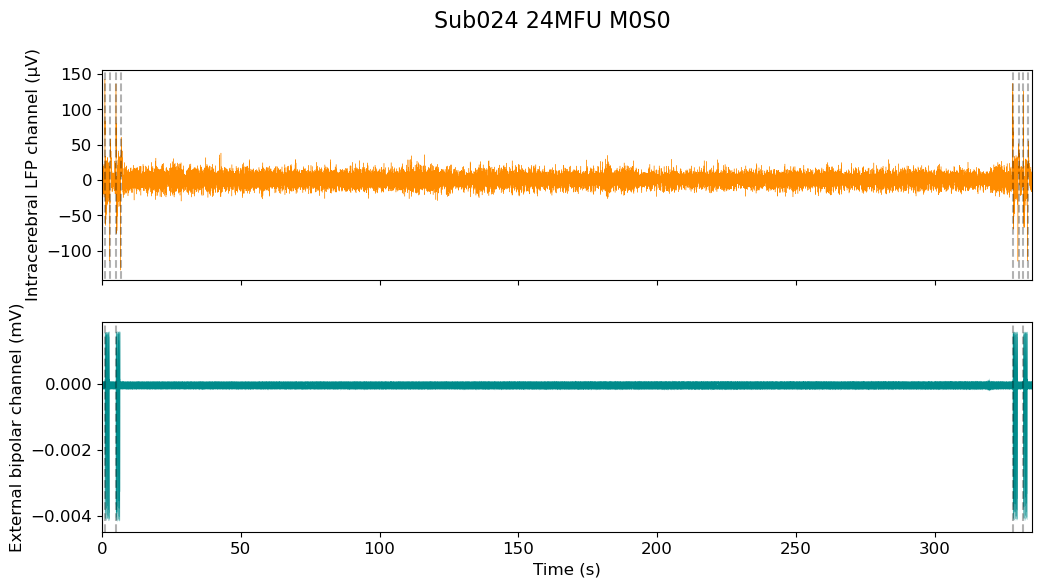

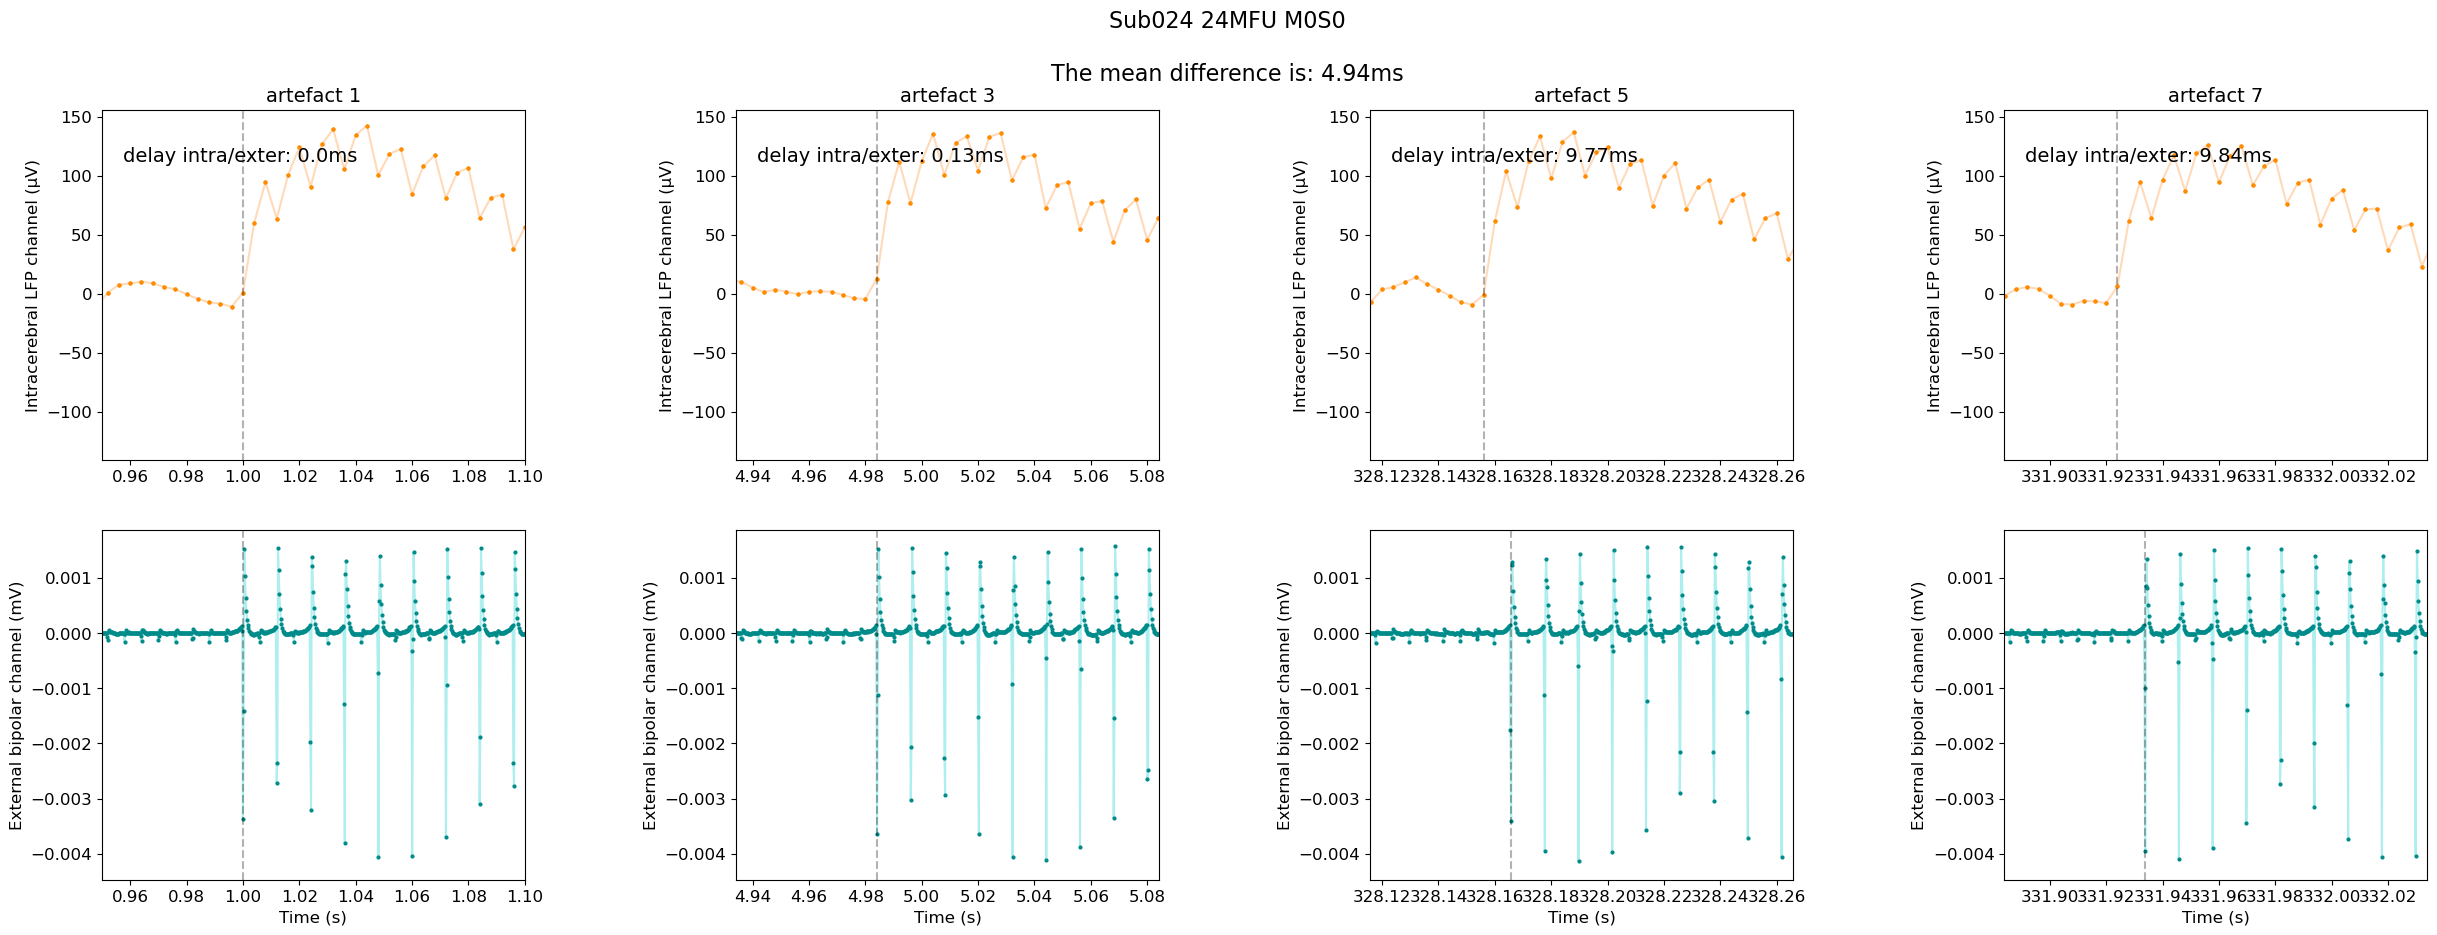

Timeshift analysis performed ! 
The result is: 9.837890625021828 ms delay at the last detected artefact, 
after a recording duration of 331.924s.


In [189]:
resync.run_timeshift_analysis(
    LFP_df_offset,
    sf_LFP,
    external_df_offset,
    sf_external,
    SHOW_FIGURES = True
)


## PART 4 : Look for packet loss ##

In [ ]:
json_fname = 'Report_Json_Session_Report_20230523T113952.json'  ## write json filename with extension
sub = '047'
resync.check_packet_loss(json_fname, sub)

## PLAYGROUND ##

##### ECG artefact verification #####

In [ ]:
importlib.reload(resync)

In [ ]:
resync.ecg(LFP_df_offset,
           sf_LFP,
           external_df_offset,
           sf_external,
           SHOW_FIGURES = True
)

##### Make quick figures #####

In [ ]:
import json

#import settings
json_path = os.path.join(os.getcwd(), 'config')
json_filename = 'config.json'  # dont forget json extension
with open(os.path.join(json_path, json_filename), 'r') as f:
    loaded_dict =  json.load(f)

#set saving path
if loaded_dict['saving_path'] == False:
    saving_path = utils.define_folders()
else:
    saving_path = os.path.join(os.path.normpath(loaded_dict['saving_path']), loaded_dict['subject_ID'])
    if not os.path.isdir(saving_path):
        os.makedirs(saving_path)


### DETECT ARTEFACTS ###

# Reselect artefact channels in the aligned (= cropped) files
LFP_channel_offset = LFP_df_offset.iloc[:,loaded_dict['LFP_ch_index']].to_numpy()  
BIP_channel_offset = external_df_offset.iloc[:,loaded_dict['BIP_ch_index']].to_numpy() 

# Generate new timescales:
LFP_timescale_offset_s = np.arange(0,(len(LFP_channel_offset)/loaded_dict['sf_LFP']),1/loaded_dict['sf_LFP'])
external_timescale_offset_s = np.arange(0,(len(BIP_channel_offset)/loaded_dict['sf_external']),1/loaded_dict['sf_external'])

filtered_external_offset = preproc.filtering(BIP_channel_offset)

In [ ]:
# Both signals aligned with all their artefacts detected:
fig, (ax1, ax2) = plt.subplots(2,1)
fig.suptitle(str(loaded_dict['subject_ID']))
fig.set_figheight(6)
fig.set_figwidth(12)
ax1.axes.xaxis.set_ticklabels([])
ax2.set_xlabel('Time (s)')
ax1.set_ylabel('Intracerebral LFP channel (µV)')
ax2.set_ylabel('External bipolar channel (mV)')
#ax1.set_xlim(0,len(LFP_channel_offset)/loaded_dict['sf_LFP']) 
#ax2.set_xlim(0,len(LFP_channel_offset)/loaded_dict['sf_LFP']) 
ax1.set_xlim(264.9,265.4) 
ax2.set_xlim(264.9,265.4)
ax1.set_ylim(-500,500)
ax1.scatter(LFP_timescale_offset_s,LFP_channel_offset,color='darkorange',zorder=1, s=3)
ax2.plot(external_timescale_offset_s,filtered_external_offset, color='darkcyan',zorder=1, linewidth=0.1) 

fig.savefig(saving_path + '\\last artefact zoomed.png',bbox_inches='tight')


In [ ]:
plt.scatter(LFP_timescale_offset_s,LFP_channel_offset,color='darkorange',zorder=1, s=5)
plt.title(str(loaded_dict['subject_ID']))
plt.xlim(265,265.4)
plt.ylim(-400,200)
plt.xlabel('Time (s)')
plt.ylabel('Intracerebral LFP channel (µV)')
plt.savefig(saving_path + '\\last artefact zoomed2.png',bbox_inches='tight')